In [2]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [3]:
df = pd.read_csv('forecasting_data.csv')
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

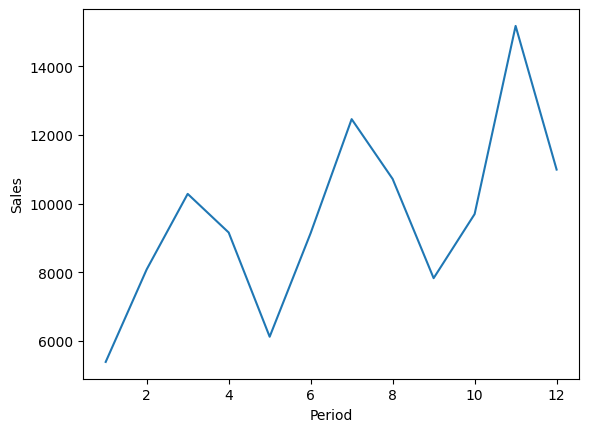

8081


In [8]:
plt.plot(df['Period'], df['Sales'])
plt.xlabel('Period')
plt.ylabel('Sales')
plt.show()

# The pattern is increases over the long term, but has short term seasonal variation

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

    Period         Sales
0      4.0   7915.666667
1      5.0   9173.000000
2      6.0   8518.666667
3      7.0   8137.666667
4      8.0   9239.000000
5      9.0  10772.000000
6     10.0  10334.000000
7     11.0   9411.666667
8     12.0  10898.333333
9     13.0  11953.333333
10    14.0  13083.500000
11    15.0  10990.000000
12    16.0           NaN


C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\354682839.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MADF = MADF.append({'Period' : i, 'Sales' : kAvg}, ignore_index = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\354682839.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MADF = MADF.append({'Period' : i, 'Sales' : kAvg}, ignore_index = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\354682839.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MADF = MADF.append({'Period' : i, 'Sales' : kAvg}, ignore_index = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\354682839.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use panda

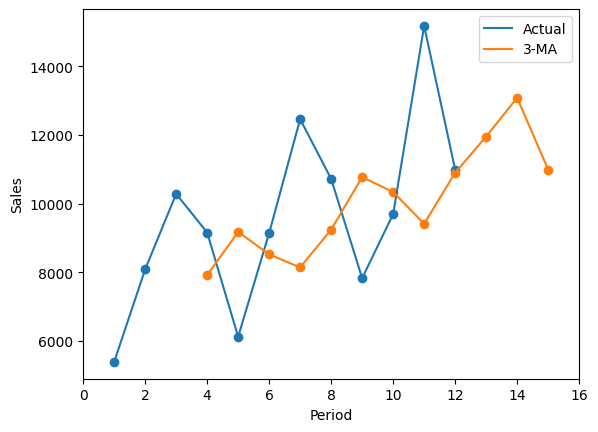

In [63]:
# Using moving average
def moving_average(df, k, to_period):
    MADF = pd.DataFrame(columns=['Period','Sales'])
    for i in range(k+1, to_period+1):
        kAvg = np.average(df['Sales'][i-k-1:i-1])
        MADF = MADF.append({'Period' : i, 'Sales' : kAvg}, ignore_index = True)
    
    return MADF

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
print(ma_df)
plt.plot(df['Period'], df['Sales'])
plt.plot(ma_df['Period'], ma_df['Sales'])
plt.scatter(df['Period'], df['Sales'])
plt.scatter(ma_df['Period'], ma_df['Sales'])
ax.legend(labels=["Actual", "3-MA"])
plt.xlabel('Period')
plt.ylabel('Sales')
plt.xlim([0,16])
plt.show()

### Using exponential smoothing

C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\561692478.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  es_df = es_df.append({'Period' : df['Period'][0], 'Sales' : df['Sales'][0]}, ignore_index = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\561692478.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  es_df = es_df.append({'Period' : i + 2, 'Sales' : sales}, ignore_index = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\561692478.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  es_df = es_df.append({'Period' : i + 2, 'Sales' : sales}, ignore_index = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\561692478.py:7: FutureWarning: The frame.append method is deprecated and will be removed fr

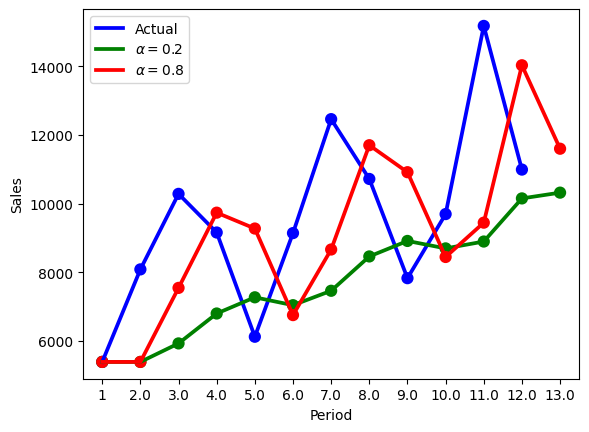

In [43]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df = es_df.append({'Period' : df['Period'][0], 'Sales' : df['Sales'][0]}, ignore_index = True)

    for i in range(len(df)):
        sales = alpha * df['Sales'][i] +  (1 - alpha) * es_df['Sales'][i]
        es_df = es_df.append({'Period' : i + 2, 'Sales' : sales}, ignore_index = True)
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
#es_df_05 = exponential_smoothing(df, 0.5)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')
#sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_05, color='y')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$" , r"$\alpha=0.5$"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality

C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\973512154.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
C:\Users\Admin\AppData\Local\Temp\ipykernel_25308\973512154.py:41: RankWarning: Polyfit may be poorly conditioned
  season_df = predict_with_seasonality(df, [13,14,15,16])


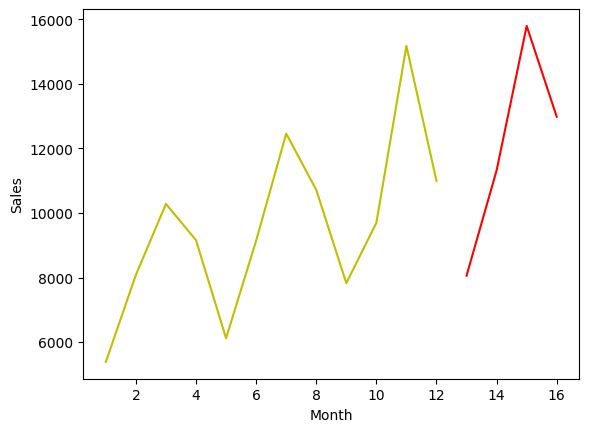

In [47]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)
    
    avg_df = season_df.apply(np.mean)
    
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df['I']/avg_df['I']
    seasonal_index_df['II'] = season_df['II']/avg_df['II']
    seasonal_index_df['III'] = season_df['III']/avg_df['III']
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis = 1)
    
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Sales'] = seasonal_index_df['Avg']*average_predict
    forecast_df['Period'] = months
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

# 4.Evaluation: compare the above implemented methods

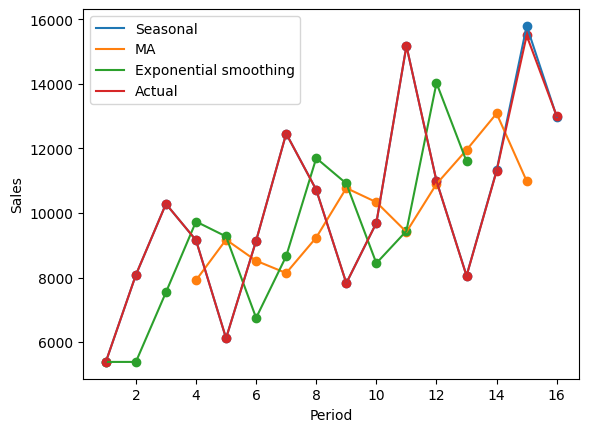

In [53]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)
seasonalDf = pd.concat([df, season_df])

f, ax = plt.subplots(1, 1)

plt.plot(seasonalDf['Period'], seasonalDf['Sales'])
plt.plot(ma_df['Period'], ma_df['Sales'])
plt.plot(es_df_08['Period'], es_df_08['Sales'])
plt.plot(eval_df['Period'], eval_df['Sales'])
plt.scatter(seasonalDf['Period'], seasonalDf['Sales'])
plt.scatter(ma_df['Period'], ma_df['Sales'])
plt.scatter(es_df_08['Period'], es_df_08['Sales'])
plt.scatter(eval_df['Period'], eval_df['Sales'])
plt.legend(labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.xlabel('Period')
plt.ylabel('Sales')
plt.show()

In [71]:
print(eval_df['Sales'][12:16])
print(ma_df['Sales'][9:13])
ma_df = ma_df.shift(3)
MAD = np.absolute(eval_df['Sales'][12:16] - ma_df['Sales'][9:13]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - es_df_02['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - es_df_08['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - seasonalDf['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

12     8050
13    11300
14    15500
15    13000
Name: Sales, dtype: int64
9     11953.333333
10    13083.500000
11    10990.000000
12             NaN
Name: Sales, dtype: float64
MAD of 3-MA: 3903.333333333334
MAD of Exponential smoothing with alpha=0.2: 2267.8234691993603
MAD of Exponential smoothing with alpha=0.8: 3548.037820375039
MAD of Seasonality Method: 85.88221407246692


In [72]:
MSE = (eval_df['Sales'][12:16] - ma_df['Sales'][12:16]) * (eval_df['Sales'][12:16] - ma_df['Sales'][12:16]) 
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = (eval_df['Sales'][12:16] - es_df_02['Sales'][12:16]) * (eval_df['Sales'][12:16] - es_df_02['Sales'][12:16]) 
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = (eval_df['Sales'][12:16] - es_df_08['Sales'][12:16]) * (eval_df['Sales'][12:16] - es_df_08['Sales'][12:16]) 
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = (eval_df['Sales'][12:16] - seasonalDf['Sales'][12:16]) * (eval_df['Sales'][12:16] - seasonalDf['Sales'][12:16]) 
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 15236011.111111116
MSE of Exponential smoothing with alpha=0.2: 5143023.287451422
MSE of Exponential smoothing with alpha=0.8: 12588572.374811657
MSE of Seasonality Method: 22206.089646320645
